# Playground for Building Function Approximator Tools

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional
import math

%matplotlib inline

## Minimum Sample Size for Catching Coin Toss Cheaters
Inspired by this video: https://www.youtube.com/watch?v=XTcP4oo4JI4&t=1178s

Let, $p_f, p_b$ be the probabilities of a fair and biased coin respectively.

Let $\alpha, \beta$ be the desired FPR and effect size target respectively.

We want to find $n$ := the minimum sample size to satisfy those targets where the test is: identify a cheater (positive) if they hit more than $T$ heads ($T$ is determined based on those parameters).

Once we define a function, we'll fit it using the function approximator framework.

In [11]:
def binomial_pdf(n: int, p: float, k: float) -> float:
    return math.comb(n, k) * p**k * (1-p)**(n-k)

In [12]:
def compute_min_threshold_for_alpha(p: float, alpha: float, n: int) -> int:
    # find the minimum T such that probability of hitting at least T heads on n tosses is <= alpha

    total_probability = 0

    # iterate backwards
    for t in range(n, -1, -1):
        total_probability += binomial_pdf(n, p, t)

        if total_probability > alpha:
            return t + 1
    
    # if we get here, something went wrong - the final probability should be 1 and alpha < 1
    raise ValueError(f"Ensure alpha is < 1.0")

In [18]:
def compute_statistical_power(p: float, n: int, t: int) -> float:
    total_probability = 0
    for k in range(t, n + 1):
        total_probability += binomial_pdf(n, p, k)
    
    return total_probability


In [28]:
MAX_N = 1000
def min_sample_for_test(p_f: float, p_b: float, alpha: float, beta: float) -> Optional[int]:
    # validation logic
    assert 0 <= p_f <= 1
    assert 0 <= p_b <= 1
    assert p_f < p_b
    assert 0 < alpha < 1
    assert 0 < beta < 1

    for n in range(1, MAX_N + 1):
        t = compute_min_threshold_for_alpha(p_f, alpha, n)
        power = compute_statistical_power(p_b, n, t)
        if power >= beta:
            return n
    
    return None


In [22]:
min_sample_for_test(
    p_f=0.5,
    p_b=0.75,
    alpha=0.05,
    beta=0.8,
)

23

In [23]:
# static parameter values
parameter_values = {
    "p_f": 0.5,
    "p_b": 0.75,
    "alpha": 0.05,
    "beta": 0.8,
}

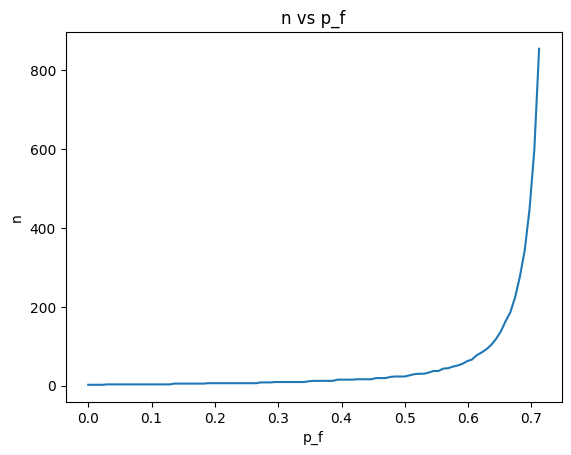

In [26]:
# plot n vs p_f fixing the other parameters
p_f = np.linspace(0, parameter_values["p_b"] - 0.0001, 100)
n_vals = np.array([min_sample_for_test(p_f, parameter_values["p_b"], parameter_values["alpha"], parameter_values["beta"]) for p_f in p_f])
plt.plot(p_f, n_vals)
plt.xlabel("p_f")
plt.ylabel("n")
plt.title("n vs p_f")
plt.show()

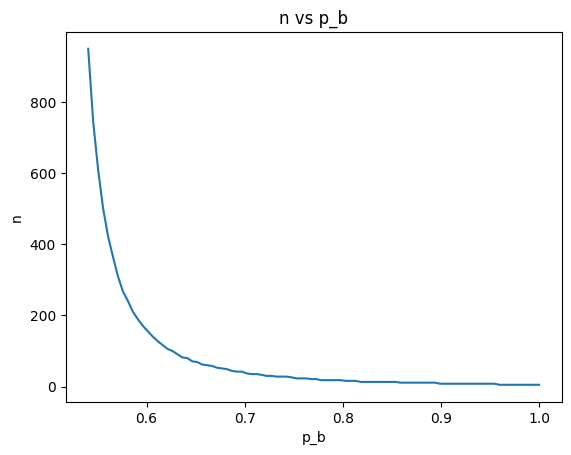

In [27]:
# plot n vs p_b fixing the other parameters
p_b = np.linspace(parameter_values["p_f"] + 0.0001, 1, 100)
n_vals = np.array([min_sample_for_test(parameter_values["p_f"], p_b, parameter_values["alpha"], parameter_values["beta"]) for p_b in p_b])
plt.plot(p_b, n_vals)
plt.xlabel("p_b")
plt.ylabel("n")
plt.title("n vs p_b")
plt.show()

In [30]:
min_sample_for_test(parameter_values["p_f"], 1.0, parameter_values["alpha"], parameter_values["beta"])

5

In [31]:
min_sample_for_test(0.0, parameter_values["p_f"], parameter_values["alpha"], parameter_values["beta"])

3

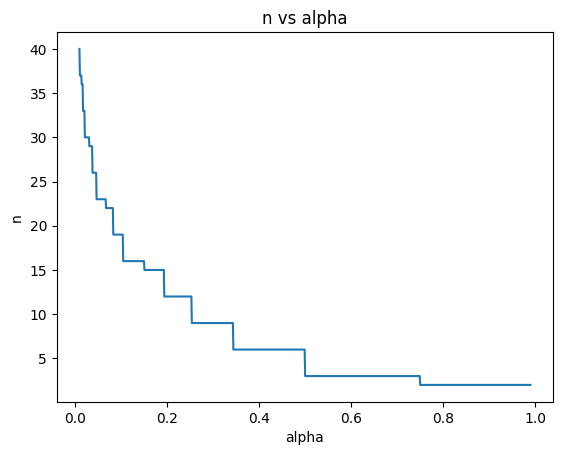

In [35]:
# plot n vs alpha fixing the other parameters
alpha = np.linspace(0.01, 0.99, 1000)
n_vals = np.array([min_sample_for_test(parameter_values["p_f"], parameter_values["p_b"], alpha, parameter_values["beta"]) for alpha in alpha])
plt.plot(alpha, n_vals)
plt.xlabel("alpha")
plt.ylabel("n")
plt.title("n vs alpha")
plt.show()

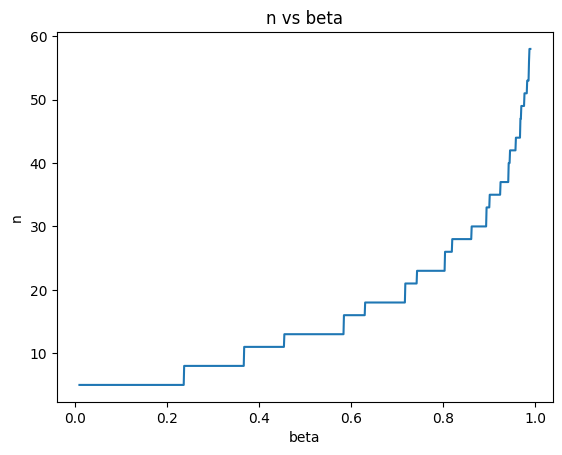

In [36]:
# plot n vs beta fixing the other parameters
beta = np.linspace(0.01, 0.99, 1000)
n_vals = np.array([min_sample_for_test(parameter_values["p_f"], parameter_values["p_b"], parameter_values["alpha"], beta) for beta in beta])
plt.plot(beta, n_vals)
plt.xlabel("beta")
plt.ylabel("n")
plt.title("n vs beta")
plt.show()